In [37]:
### code to generate toy dataset in the same folder. 

import os
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

# Setup
IMG_SIZE = 64
NORMAL_SHAPES = ['circle', 'square']
NORMAL_COLORS = ['red', 'green', 'blue']
NUM_NORMAL = 200
NUM_ANOMALY = 20
OUTPUT_DIR = "dataset"
SEED = 42
random.seed(SEED)

# Utility: Create folders
def make_dirs():
    for split in ['train', 'test']:
        for cls in ['normal', 'anomalous']:
            os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

# Generate a normal image
def generate_normal_image():
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), 'black')
    draw = ImageDraw.Draw(img)
    shape = random.choice(NORMAL_SHAPES)
    color = random.choice(NORMAL_COLORS)
    x0, y0, x1, y1 = 16, 16, 48, 48

    if shape == 'circle':
        draw.ellipse([x0, y0, x1, y1], fill=color)
    elif shape == 'square':
        draw.rectangle([x0, y0, x1, y1], fill=color)

    return img

# Generate an anomalous image (plain white)
def generate_anomalous_image():
    return Image.new('RGB', (IMG_SIZE, IMG_SIZE), 'white')

# Save image
def save_image(img, split, cls, idx):
    path = os.path.join(OUTPUT_DIR, split, cls, f"{cls}_{idx:03d}.png")
    img.save(path)

# Main generation logic
def generate_dataset():
    make_dirs()

    # TRAIN: 100 normal
    print("Generating training set...")
    for i in tqdm(range(100)):
        img = generate_normal_image()
        save_image(img, 'train', 'normal', i)

    # TEST: 100 normal + 20 anomalous
    print("Generating test set...")
    for i in tqdm(range(100)):
        img = generate_normal_image()
        save_image(img, 'test', 'normal', i)
    for i in tqdm(range(20)):
        img = generate_anomalous_image()
        save_image(img, 'test', 'anomalous', i)

generate_dataset()

Generating training set...


100%|██████████| 100/100 [00:00<00:00, 4860.54it/s]


Generating test set...


100%|██████████| 20/20 [00:00<00:00, 5509.76it/s]


In [38]:
# 0) Point to your CNN‑DAGMM folder *before* any imports
import sys, importlib
from pathlib import Path

cnn_dir = Path.cwd().parent / "cnn_dagmm"
sys.path.insert(0, str(cnn_dir))

# 1) Import & force‑reload to clear any old cache
import compression_network, model
importlib.reload(compression_network)
importlib.reload(model)

# 2) Verify you’re using the right files
print("CompressionNetwork from:", compression_network.__file__)
print("DAGMM   from:",           model.__file__)


CompressionNetwork from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/compression_network.py
DAGMM   from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/model.py


In [39]:
# %% [markdown]
# # DAGMM Anomaly Detection with Sampled Anomalies in Train

# %% [code]
# 1) Make your DAGMM code importable
import sys, os
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / "cnn_dagmm"))

# %% [code]
# 2) Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from collections import Counter

from model import DAGMM  # your revised model.py

# %% [code]
# 3) Data transforms & loaders (images → flattened vectors)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder("dataset/train", transform=transform, allow_empty=True)
test_ds  = datasets.ImageFolder("dataset/test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)

# Print ground‑truth counts
print("Train class counts:", {train_ds.classes[k]: v for k,v in Counter(train_ds.targets).items()})
print("Test  class counts:", {test_ds.classes[k]: v for k,v in Counter(test_ds.targets).items()})

Train class counts: {'normal': 100}
Test  class counts: {'anomalous': 20, 'normal': 100}


In [40]:
for imgs, labels in train_loader:
    # labels = labels.numpy()
    print(imgs.shape)
    break

torch.Size([32, 3, 64, 64])


tensor(0.3267, grad_fn=<AddBackward0>) tensor(1838.3203, grad_fn=<MeanBackward0>) tensor(551.9995, grad_fn=<SumBackward0>)
tensor(0.2879, grad_fn=<AddBackward0>) tensor(1690.7438, grad_fn=<MeanBackward0>) tensor(551.1047, grad_fn=<SumBackward0>)
tensor(0.2697, grad_fn=<AddBackward0>) tensor(1525.8197, grad_fn=<MeanBackward0>) tensor(550.1173, grad_fn=<SumBackward0>)
Epoch 1/50 — avg train loss: 835.5159
tensor(0.2518, grad_fn=<AddBackward0>) tensor(1413.3766, grad_fn=<MeanBackward0>) tensor(549.1574, grad_fn=<SumBackward0>)
tensor(0.2384, grad_fn=<AddBackward0>) tensor(1349.9307, grad_fn=<MeanBackward0>) tensor(548.2299, grad_fn=<SumBackward0>)
tensor(0.2281, grad_fn=<AddBackward0>) tensor(1295.0344, grad_fn=<MeanBackward0>) tensor(547.3163, grad_fn=<SumBackward0>)
Epoch 2/50 — avg train loss: 675.8798
tensor(0.2219, grad_fn=<AddBackward0>) tensor(1230.1422, grad_fn=<MeanBackward0>) tensor(546.4108, grad_fn=<SumBackward0>)
tensor(0.2164, grad_fn=<AddBackward0>) tensor(1211.5247, grad_f

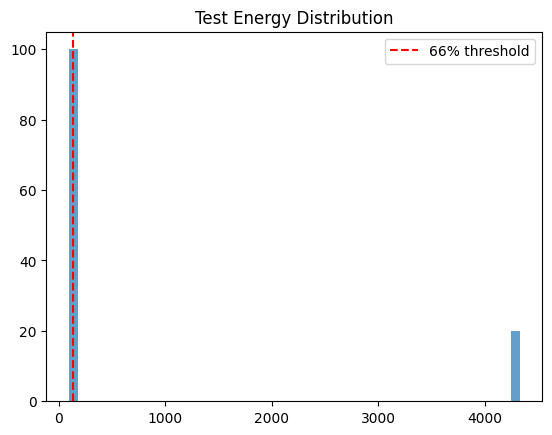

In [41]:


# %% [code]
# 4) Model + optimizer
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
n_features = 3 * 64 * 64

model = DAGMM(
    input_dim        = 3 * 64 * 64,     # still required by signature but not forwarded to CompressionNetwork
    latent_dim       = 90,
    n_gmm_components = 6,
    comp_kwargs      = {'latent_dim': 90},  # now cleanly matches CompressionNetwork
    est_kwargs       = {'hidden_dims': [128], 'activation': torch.nn.Tanh, 'dropout': 0.3},
    device           = device
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# %% [code]
# 5) Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        x = imgs.to(device) 
        out  = model(x)
        loss = model.loss_function(x, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

# %% [code]
# 6) Scoring test set & thresholding
model.eval()
energies = []
with torch.no_grad():
    for imgs, _ in test_loader:
        x = imgs.to(device)
        energies.append(model(x)['energy'].cpu())
energies = torch.cat(energies)

# 95th‐percentile threshold
thr = energies.quantile(0.70)
mask = energies > thr
print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")

# %% [code]
# 7) (Optional) Visualize
import matplotlib.pyplot as plt
plt.hist(energies.numpy(), bins=50, alpha=0.7)
plt.axvline(thr, color='r', linestyle='--', label='66% threshold')
plt.legend(); plt.title("Test Energy Distribution"); plt.show()


In [42]:
# %% [code]
# 6) Scoring test set & thresholding
model.eval()
energies = []
with torch.no_grad():
    for imgs, _ in test_loader:
        x = imgs.to(device)
        energies.append(model(x)['energy'].cpu())
energies = torch.cat(energies)

# 95th‐percentile threshold
thr = energies.quantile(0.90)
mask = energies > thr
print(energies)
print(mask)
print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")

# # %% [code]
# # 7) (Optional) Visualize
# import matplotlib.pyplot as plt
# plt.hist(energies.numpy(), bins=50, alpha=0.7)
# plt.axvline(thr, color='r', linestyle='--', label='66% threshold')
# plt.legend(); plt.title("Test Energy Distribution"); plt.show()


tensor([4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354,
        4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354,
        4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354, 4324.2354,
        4324.2354, 4324.2354,   98.7730,   98.7730,   93.7499,  108.5247,
          93.7499,  132.8648,   93.7499,  114.1434,   98.7730,  132.8648,
         114.1434,  114.1434,  134.5560,  132.8648,   98.7730,  134.5560,
          93.7499,   98.7730,  132.8648,   93.7499,   93.7499,  114.1434,
          98.7730,  134.5560,   98.7730,   98.7730,   98.7730,  114.1434,
          93.7499,   93.7499,  108.5247,  108.5247,  114.1434,  114.1434,
          93.7499,  108.5247,   98.7730,  132.8648,   93.7499,  132.8648,
         134.5560,   98.7730,   98.7730,  132.8648,  132.8648,  108.5247,
         132.8648,  132.8648,  132.8648,  108.5247,  114.1434,  132.8648,
          93.7499,  114.1434,  132.8648,  114.1434,   93.7499,  108.5247,
          98.7730,  132.8648,   93.749

In [43]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1) Recompute energies and collect true labels
model.eval()
energies = []
y_true   = []
with torch.no_grad():
    for imgs, labels in test_loader:
        x = imgs.to(device)                       # CNN takes [B,3,64,64]
        out = model(x)
        energies.append(out['energy'].cpu())      # [B]
        y_true.append(labels)
energies = torch.cat(energies)                  # [N_test]
y_true   = torch.cat(y_true)                    # [N_test]

# 2) Identify top 30% highest‐energy samples as anomalies
#    70th percentile cutoff → top 30% above this
thr = energies.quantile(0.80)


# 3) Predictions
# 3) Logical not then cast
y_pred_inv = (~(energies > thr)).int() #we want 1 for normal, 0 for anomaly. High energy = anomaly. 
y_pred = y_pred_inv.int() # 0 for normal, 1 for anomaly
# 4) Metrics
print("Threshold for top 30% anomalies:", thr.item())
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))

acc = (y_true == y_pred).float().mean() * 100
print(f"\nAccuracy: {acc:.2f}%\n")

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# 5) ROC‑AUC (still informative even though we fix the cutoff by proportion)
auc = roc_auc_score(y_true, -energies)  # invert since lower energy = more normal
print(f"\nROC‑AUC (energy as score): {auc:.3f}")


Threshold for top 30% anomalies: 134.5559844970703

Confusion matrix:
[[ 20   0]
 [  0 100]]

Accuracy: 100.00%

Classification report:
              precision    recall  f1-score   support

   anomalous       1.00      1.00      1.00        20
      normal       1.00      1.00      1.00       100

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120


ROC‑AUC (energy as score): 1.000
